## Дерева решений

Группа 4:
1. Барановская Марианна
2. Буренкова Юлия
3. Колпакова Оксана
4. Тоидзе Анна

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [198]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки. В отличие от проекта, который вас ждет, здесь мы будем работать не с сырыми данными (аудиодорожками), а уже в осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [199]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [200]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [202]:
data.isnull().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [203]:
data.corr()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
Popularity,1.000000,0.167213,0.051538,0.005901,0.124915,0.016584,0.031664,-0.125410,-0.167661,-0.072298,0.054824,-0.006050,-0.031118,0.067062,0.161072
danceability,0.167213,1.000000,-0.093838,0.006702,0.059723,-0.067135,0.199042,0.009055,-0.200752,-0.109485,0.444548,-0.183527,-0.121624,0.137455,-0.097681
energy,0.051538,-0.093838,1.000000,0.015934,0.767869,-0.035880,0.125427,-0.745963,-0.180276,0.195634,0.222998,0.210224,0.245768,0.145281,0.217328
key,0.005901,0.006702,0.015934,1.000000,0.002660,-0.112452,0.001822,-0.009112,0.001411,0.015125,0.031744,0.013965,0.014547,0.006965,-0.007829
loudness,0.124915,0.059723,0.767869,0.002660,1.000000,-0.033650,0.096027,-0.612824,-0.343672,0.112022,0.181086,0.164272,0.172010,0.127775,0.177872
mode,0.016584,-0.067135,-0.035880,-0.112452,-0.033650,1.000000,-0.074609,0.024035,-0.026771,-0.001563,-0.002986,0.021211,-0.069307,-0.019989,-0.044740
speechiness,0.031664,0.199042,0.125427,0.001822,0.096027,-0.074609,1.000000,-0.086648,-0.067632,0.070406,0.053885,0.048948,0.005044,0.056237,-0.059349
acousticness,-0.125410,0.009055,-0.745963,-0.009112,-0.612824,0.024035,-0.086648,1.000000,0.174139,-0.111393,-0.122547,-0.168318,-0.322583,-0.133936,-0.237138
instrumentalness,-0.167661,-0.200752,-0.180276,0.001411,-0.343672,-0.026771,-0.067632,0.174139,1.000000,-0.047189,-0.228144,-0.038586,-0.004551,-0.061745,-0.025343
liveness,-0.072298,-0.109485,0.195634,0.015125,0.112022,-0.001563,0.070406,-0.111393,-0.047189,1.000000,0.021076,0.033515,0.053885,0.021546,0.045309


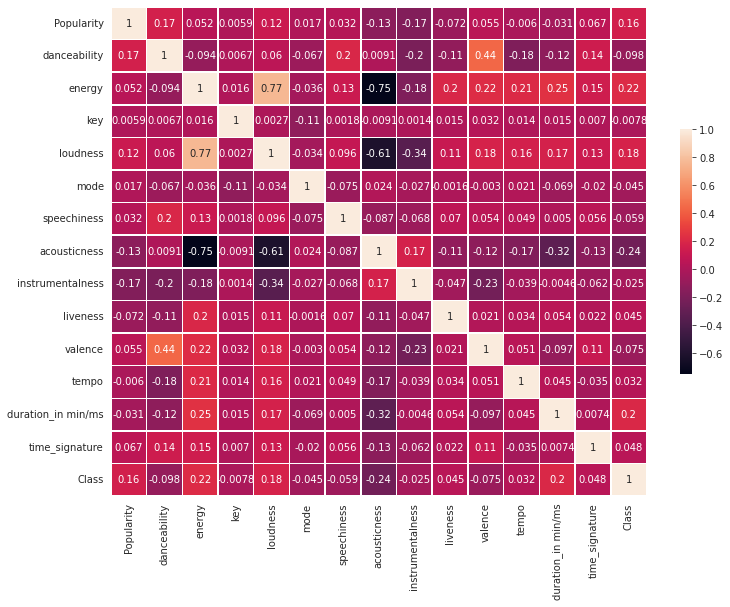

In [204]:
sns.heatmap(data.corr(), annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

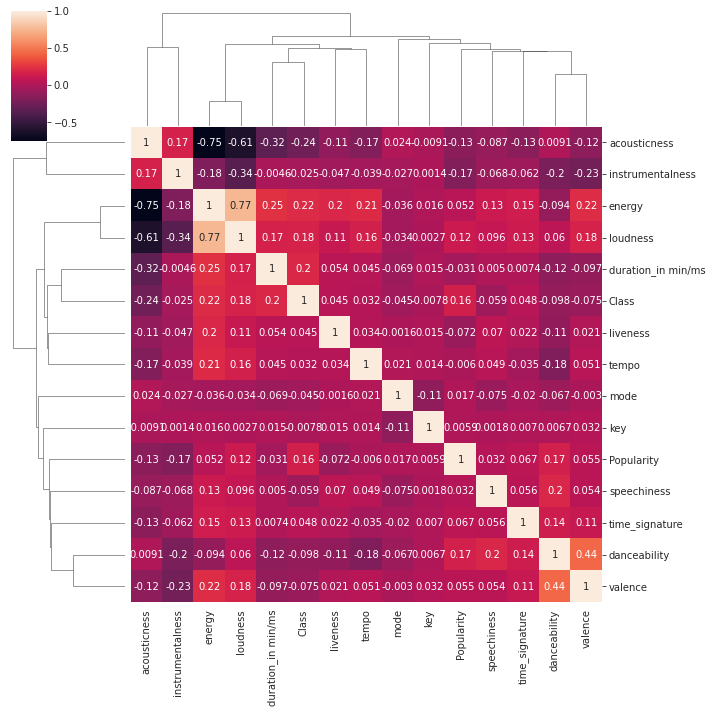

In [205]:
sns.clustermap(data.corr(), annot=True)

**Variables correlation distribution with Class** 

In [206]:
# Take a look at variables with high correlation with Class
abs(data.corr()["Class"]).sort_values()

key                   0.007829
instrumentalness      0.025343
tempo                 0.031737
mode                  0.044740
liveness              0.045309
time_signature        0.047989
speechiness           0.059349
valence               0.075116
danceability          0.097681
Popularity            0.161072
loudness              0.177872
duration_in min/ms    0.203678
energy                0.217328
acousticness          0.237138
Class                 1.000000
Name: Class, dtype: float64

**Variables with high correlation with each other**

In [207]:
unstacked_abs_corr = data.corr().abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-10:]

loudness          instrumentalness    0.343672
instrumentalness  loudness            0.343672
danceability      valence             0.444548
valence           danceability        0.444548
loudness          acousticness        0.612824
acousticness      loudness            0.612824
energy            acousticness        0.745963
acousticness      energy              0.745963
loudness          energy              0.767869
energy            loudness            0.767869
dtype: float64

In [208]:
# sns.pairplot(data);

In [209]:
data['Artist Name'].value_counts()

Backstreet Boys    69
Westlife           60
Britney Spears     54
Omer Adam          48
Eyal Golan         48
                   ..
Rocky Trail         1
Smerz               1
lavender            1
Fear Culture        1
Beherit             1
Name: Artist Name, Length: 9149, dtype: int64

## Substituting nans

In [210]:
data.isnull().sum() 

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [211]:
cols = ['instrumentalness', 'key', 'Popularity']
# print((data[cols] == 0).sum())

In [212]:
data[cols][data[cols].isna().any(axis=1)]

,instrumentalness,key,Popularity
0,NaN,1.0,60.0
3,NaN,10.0,66.0
9,NaN,1.0,14.0
11,NaN,9.0,59.0
12,NaN,1.0,34.0
...,...,...,...
17978,NaN,5.0,55.0
17982,0.000142,NaN,29.0
17985,0.174000,NaN,2.0
17986,NaN,5.0,71.0


In [213]:
data["key"].value_counts()

7.0     2097
2.0     1994
9.0     1961
1.0     1680
4.0     1549
11.0    1476
5.0     1397
6.0     1190
8.0     1119
10.0    1010
3.0      509
Name: key, dtype: int64

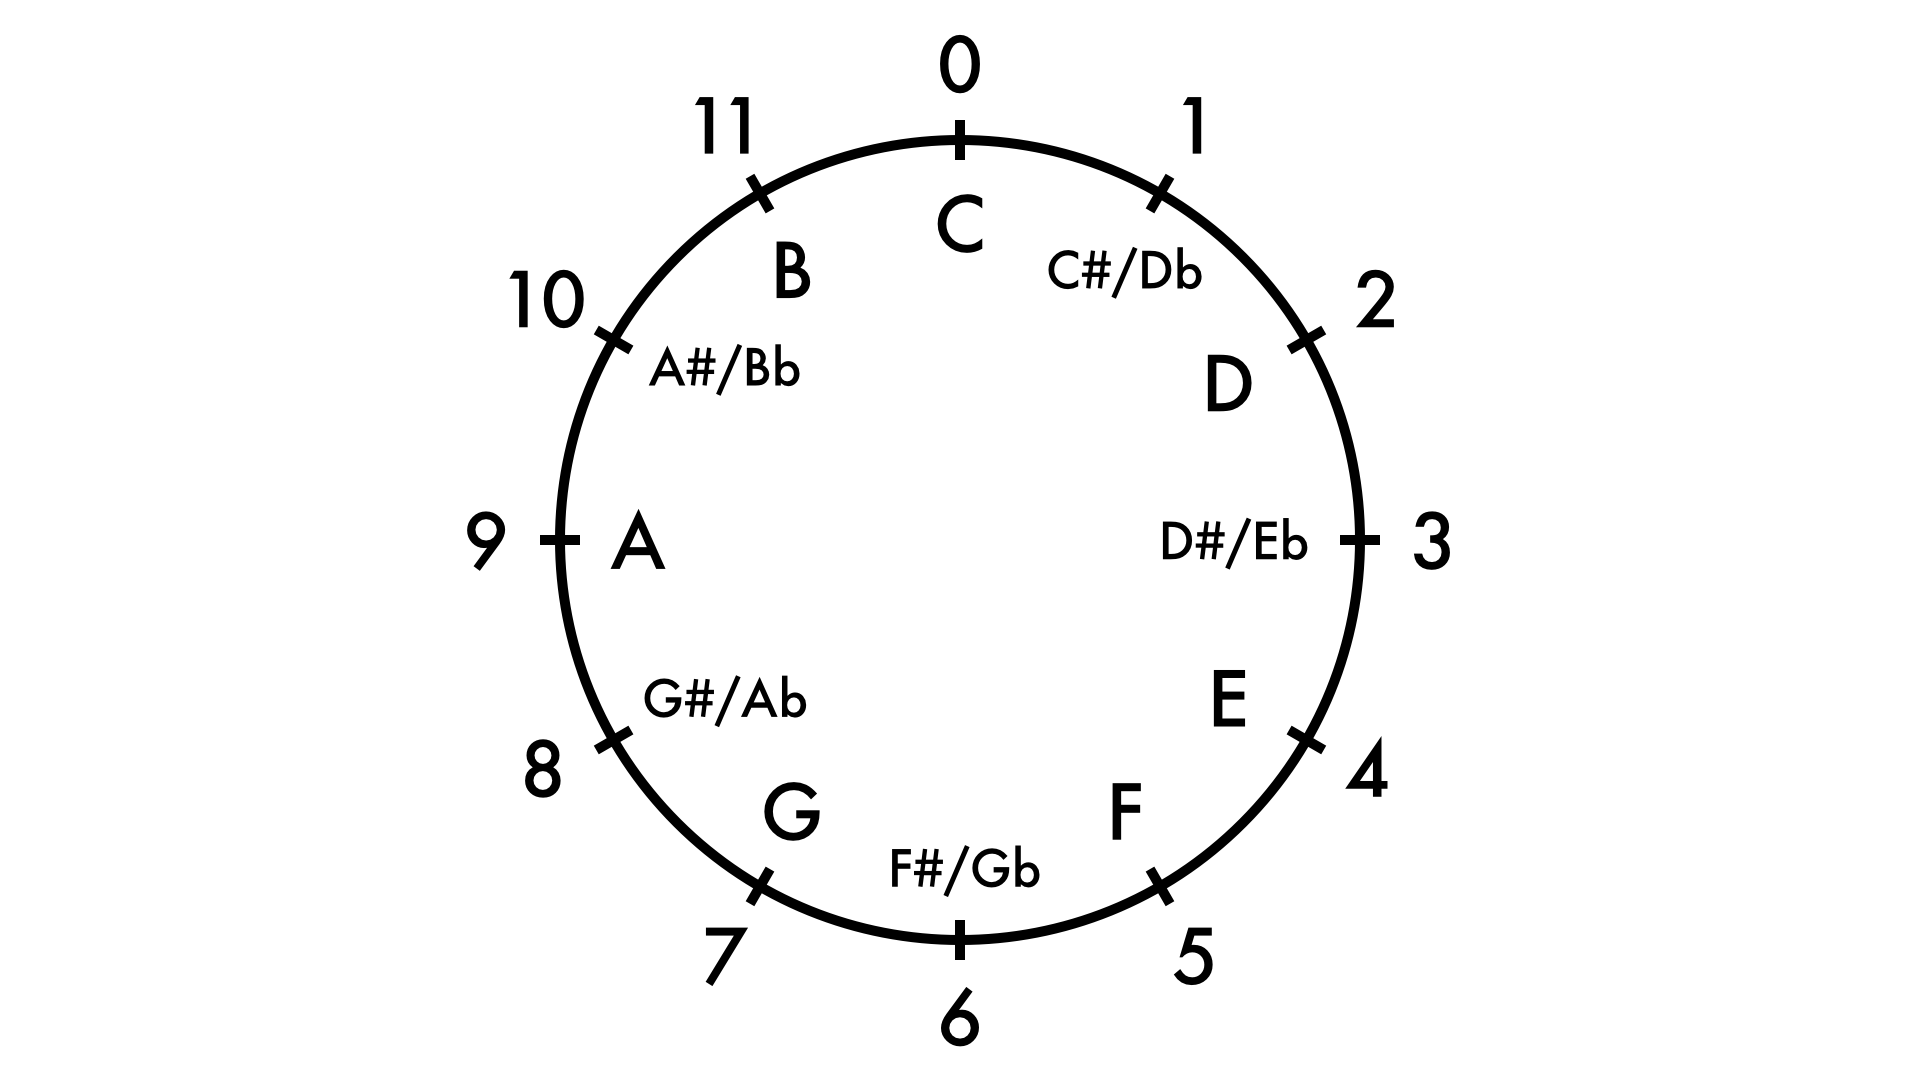

It is obvious that one key - C - is missing.

In [214]:
data[cols] = data[cols].replace(np.nan, 0)

In [215]:
data.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

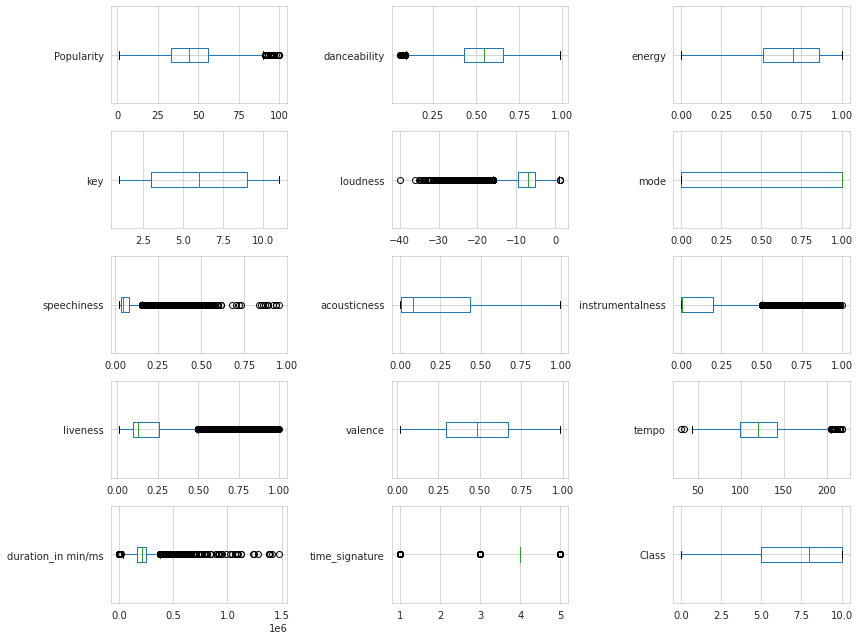

In [287]:
fig, axes = plt.subplots(5, 3)

for i, el in enumerate(list(data.drop(['Artist Name', 'Track Name'], axis=1).columns.values)):
    data.boxplot(el, ax=axes.flatten()[i], vert=False)

plt.tight_layout()
plt.show()

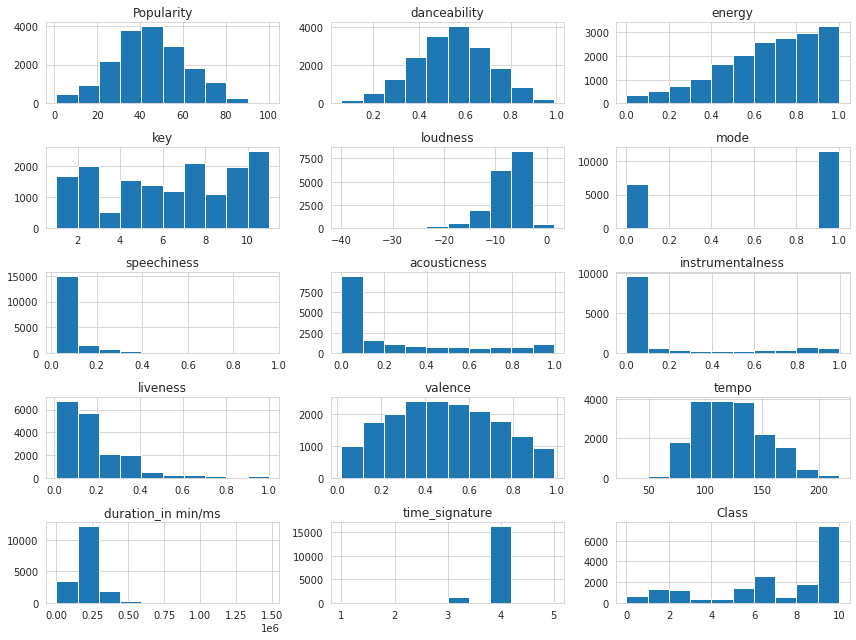

In [288]:
fig, axes = plt.subplots(5, 3)

for i, el in enumerate(list(data.drop(['Artist Name', 'Track Name'], axis=1).columns.values)):
    data.hist(el, ax=axes.flatten()[i])

plt.tight_layout() 
plt.show()

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [151]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = data.drop(['Track Name', 'Class'], axis=1)
X = pd.get_dummies(X)

y = data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [152]:
# если без подкручивания параметров :
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred_basic = cls.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_basic), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_basic, average="macro"), 4)}')

accuracy_score:	0.3992
precision_score:0.4836
recall_score: 	0.4879
f1_score: 	0.4849


In [153]:
# словарик параметров для тюнинга модели
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(2, 20, 4), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
cls_m = DecisionTreeClassifier()
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=5, n_jobs=-1)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4)


accuracy_score:	0.485
precision_score:0.5517
recall_score: 	0.5287
f1_score: 	0.5266


In [155]:
y_dgs_pred

array([ 5, 10,  0, ...,  9,  2, 10])

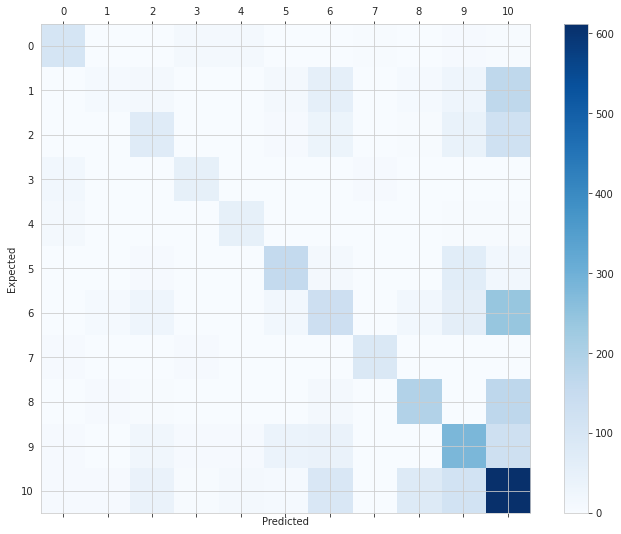

In [156]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_dgs_pred)
# print('Confusion matrix:\n', conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(list(range(11)))
ax.set_yticks(list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## Labelencoding Artist names

In [159]:
from sklearn.preprocessing import LabelEncoder

le_data = data.copy()

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
le_data['Artist Name'] = labelencoder.fit_transform(le_data['Artist Name'])
le_data

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1182,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,0.000000,0.0849,0.8990,134.071,234596.0,4,5
1,1092,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,7899,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,1987,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,0.000000,0.1220,0.5690,107.033,173968.0,4,5
4,6283,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,3042,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6
17992,5122,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2
17993,7032,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8
17994,797,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8


In [160]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = le_data.drop(['Track Name', 'Class'], axis=1)

y = le_data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
# если без подкручивания параметров :
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred_basic = cls.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_basic), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_basic, average="macro"), 4)}')

accuracy_score:	0.3758
precision_score:0.4573
recall_score: 	0.4525
f1_score: 	0.4541


In [162]:
# словарик параметров для тюнинга модели
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(2, 20, 4), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
cls_m = DecisionTreeClassifier()
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=5, n_jobs=-1)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=4)


accuracy_score:	0.4781
precision_score:0.5486
recall_score: 	0.5074
f1_score: 	0.5091


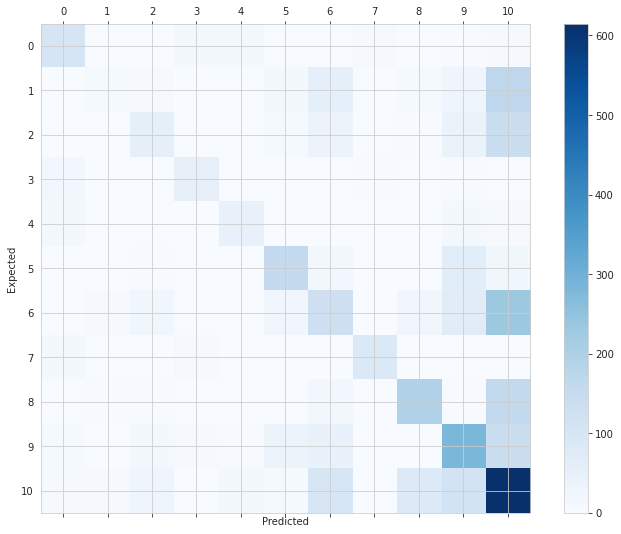

In [163]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_dgs_pred)
# print('Confusion matrix:\n', conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(list(range(11)))
ax.set_yticks(list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

(Сравнение с оптимальными параметрами для обеих моделей)

**До Labelencoding** 
* accuracy_score:	0.4794
* precision_score:0.5476
* recall_score: 	0.5084
* f1_score: 	0.5101

**С Labelencoding**
* accuracy_score:	0.4781
* precision_score:0.5486
* recall_score: 	0.5074
* f1_score: 	0.5091
> Модель особо не изменился

Попробуем убрать Artist Name, так как он с Class не коррелирует:

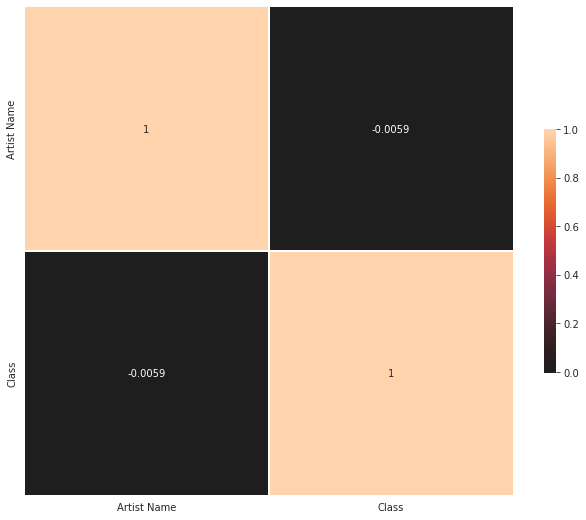

In [78]:
corr = le_data[["Artist Name", "Class"]].corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);


In [157]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = data.drop(['Artist Name', 'Track Name', 'Class'], axis=1)

y = data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# если без подкручивания параметров :
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred_basic = cls.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_basic), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_basic, average="macro"), 4)}')

accuracy_score:	0.38
precision_score:0.4606
recall_score: 	0.4715
f1_score: 	0.4652


In [113]:
# словарик параметров для тюнинга модели
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(2, 20, 4), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
cls_m = DecisionTreeClassifier()
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=5, n_jobs=-1)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=4)


accuracy_score:	0.4772
precision_score:0.5344
recall_score: 	0.5115
f1_score: 	0.5044


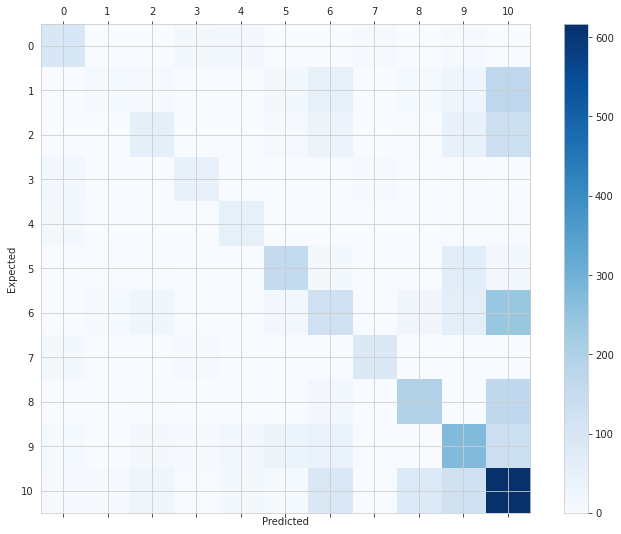

In [114]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_dgs_pred)
# print('Confusion matrix:\n', conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(list(range(11)))
ax.set_yticks(list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

(Сравнение с оптимальными параметрами для обеих моделей)

**С Artist Names** 
* accuracy_score:	0.4794
* precision_score:0.5476
* recall_score: 	0.5084
* f1_score: 	0.5101

**Без Artist name**
* accuracy_score:	0.4778
* precision_score:0.537
* recall_score: 	0.5117
* f1_score: 	0.5044

> Модель стал немножко хуже, но не особо - все таки лучше убрать Artist Name.

## Балансирование Трен. Данных

In [164]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = data.drop(['Artist Name', 'Track Name', 'Class'], axis=1)

y = data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:
y_train.value_counts()

10    3979
6     2087
9     1993
8     1472
5     1185
1     1087
2      991
0      489
7      473
3      324
4      316
Name: Class, dtype: int64

In [166]:
new_data = pd.concat([X_train, y_train], axis=1)

In [167]:
# так как классы не сбалансированны, сбалансируем.
from sklearn.utils import resample

df_01 = new_data[new_data.Class==1]
df_02 = new_data[new_data.Class==2]
df_03 = new_data[new_data.Class==3]
df_04 = new_data[new_data.Class==4]
df_05 = new_data[new_data.Class==5]
df_06 = new_data[new_data.Class==6]
df_07 = new_data[new_data.Class==7]
df_08 = new_data[new_data.Class==8]
df_09 = new_data[new_data.Class==9]
df_10 = new_data[new_data.Class==10]

upsampled_01 = resample(df_01, replace=True, n_samples=3979, random_state=123)
upsampled_02 = resample(df_02, replace=True, n_samples=3979, random_state=123)
upsampled_03 = resample(df_03, replace=True, n_samples=3979, random_state=123)
upsampled_04 = resample(df_04, replace=True, n_samples=3979, random_state=123)
upsampled_05 = resample(df_05, replace=True, n_samples=3979, random_state=123)
upsampled_06 = resample(df_06, replace=True, n_samples=3979, random_state=123)
upsampled_07 = resample(df_07, replace=True, n_samples=3979, random_state=123)
upsampled_08 = resample(df_08, replace=True, n_samples=3979, random_state=123)
upsampled_09 = resample(df_09, replace=True, n_samples=3979, random_state=123)

bal_data = pd.concat([df_10, upsampled_01, upsampled_02, upsampled_03,
                          upsampled_04, upsampled_05, upsampled_06,
                          upsampled_07, upsampled_08, upsampled_09])
 
bal_data.Class.value_counts()

10    3979
1     3979
2     3979
3     3979
4     3979
5     3979
6     3979
7     3979
8     3979
9     3979
Name: Class, dtype: int64

In [169]:
X_train = new_data.drop("Class", axis=1)
y_train = new_data["Class"]

In [171]:
# если без подкручивания параметров :
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred_basic = cls.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_basic), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_basic, average="macro"), 4)}')

accuracy_score:	0.3744
precision_score:0.4555
recall_score: 	0.4624
f1_score: 	0.458


In [172]:
# словарик параметров для тюнинга модели
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(2, 20, 4), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
cls_m = DecisionTreeClassifier()
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=5, n_jobs=-1)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)


accuracy_score:	0.4786
precision_score:0.5365
recall_score: 	0.517
f1_score: 	0.509


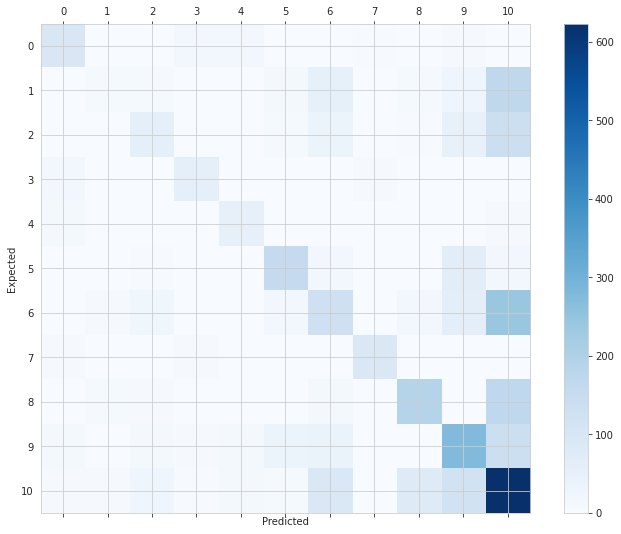

In [173]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_dgs_pred)
# print('Confusion matrix:\n', conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(list(range(11)))
ax.set_yticks(list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

**Без Artist name и без балансирования **
* accuracy_score:	0.4778
* precision_score:0.537
* recall_score: 	0.5117
* f1_score: 	0.5044

**Без Artist name и с балансированиям**
* accuracy_score:	0.4786
* precision_score:0.5365
* recall_score: 	0.517
* f1_score: 	0.509

> Модель стала немножко лучше

Сейчас буду использовать последнюю модель!

## Sklearn OneHotEncoder

In [217]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = data.drop(['Track Name', 'Class'], axis=1)

y = data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [225]:
# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Artist Name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.3919
precision_score:0.4818
recall_score: 	0.4857
f1_score: 	0.483


In [227]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fract

In [229]:
# словарик параметров для тюнинга модели
parameters = {'classifier__criterion': ['gini', 'entropy'], 
              'classifier__max_depth': range(2, 20, 4), 
              'classifier__min_samples_split': range(2, 6, 2),
              'classifier__min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
grid_search_cv_cls = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Popularity', 'danceability',
                                                   'energy', 'key', 'loudness',
                                                   'mode', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo',
                                                   'duration_in min/ms',
                               

(Сравнение с оптимальными параметрами для обеих моделей)

**С pd.get_dummies** 
* accuracy_score:	0.4794
* precision_score:0.5476
* recall_score: 	0.5084
* f1_score: 	0.5101

**С sklearn OneHotEncoder**
* accuracy_score:	0.4797
* precision_score:0.5423
* recall_score: 	0.5186
* f1_score: 	0.5178


Большой разницы нету, но с этого момента буду использовать OneHotEncoder так как с Pipeline проще.

### Задание 3. Другие модели (5 баллов за модель)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

## KNN

С исходными данными без балансирования, итд.:

In [233]:
# Loading data
data = pd.read_csv("train.csv")
X = data.drop(['Track Name', 'Class'], axis=1)
y = data["Class"]


# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_features = ['Artist Name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.4436
precision_score:0.5005
recall_score: 	0.5107
f1_score: 	0.5045


In [234]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights'])

In [241]:
parameters = [{"classifier__n_neighbors": list(range(2, 20, 3)), 
              "classifier__weights": ["uniform", "distance"],
              "classifier__metric": ['euclidean', 'manhattan', 'minkowski'],
              "classifier__n_jobs": [-1]}]

grid = GridSearchCV(clf, parameters, cv=10, scoring='f1_macro')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'classifier__metric': 'manhattan', 'classifier__n_jobs': -1, 'classifier__n_neighbors': 17, 'classifier__weights': 'uniform'}
0.5305842918275643
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Popularity', 'danceability',
                                                   'energy', 'key', 'loudness',
                                                   'mode', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo',
                                                   'duration_in min/ms',
                   

In [242]:
# классификатор
y_pred_knn = grid.best_estimator_.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_knn), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_knn, average="macro"), 4)}')

accuracy_score:	0.5053
precision_score:0.5528
recall_score: 	0.5403
f1_score: 	0.5338


## Logistic Regression

In [245]:
# Loading data
data = pd.read_csv("train.csv")
X = data.drop(['Track Name', 'Class'], axis=1)
y = data["Class"]


# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_features = ['Artist Name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.5797
precision_score:0.6203
recall_score: 	0.6213
f1_score: 	0.6091


In [246]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifie

In [248]:
parameters = [{'classifier__penalty': ['l2'],  # l1 not supported
               'classifier__C': [0.001,0.01,0.1,1,10,100],
              "classifier__n_jobs": [-1]}]

grid = GridSearchCV(clf, parameters, cv=10, scoring='f1_macro')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'classifier__C': 10, 'classifier__n_jobs': -1, 'classifier__penalty': 'l2'}
0.6365474770650426
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Popularity', 'danceability',
                                                   'energy', 'key', 'loudness',
                                                   'mode', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo',
                                                   'duration_in min/ms',
                                                   'time_signature'])

In [249]:
# классификатор
y_pred_log = grid.best_estimator_.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_log), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_log, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_log, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_log, average="macro"), 4)}')

accuracy_score:	0.5881
precision_score:0.641
recall_score: 	0.6398
f1_score: 	0.636


## Random Forest

In [251]:
# Loading data
data = pd.read_csv("train.csv")
X = data.drop(['Track Name', 'Class'], axis=1)
y = data["Class"]


# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_features = ['Artist Name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.5181
precision_score:0.6108
recall_score: 	0.5688
f1_score: 	0.5812


In [256]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__bootstrap', 'classifier__ccp_alpha'

In [259]:
#max_features
# Number of trees in random forest
n_estimators = list(range(30, 150, 30))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(1, 200, 20))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap,
               'classifier__n_jobs': [-1]}

grid = GridSearchCV(clf, parameters, cv=10, scoring='f1_macro')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

KeyboardInterrupt: 

Несколько (<4 часа) ждала - не посчиталось.

In [ ]:
#max_features
# Number of trees in random forest
n_estimators = list(range(30, 150, 30))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(1, 200, 20))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap,
               'classifier__n_jobs': [-1]}

grid = GridSearchCV(clf, parameters, cv=10, scoring='f1_macro')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
# классификатор
y_pred_rdf = grid.best_estimator_.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_rdf), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_rdf, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_rdf, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_rdf, average="macro"), 4)}')

## AdaBoostClassifier

In [261]:
# Loading data
data = pd.read_csv("train.csv")
X = data.drop(['Track Name', 'Class'], axis=1)
y = data["Class"]


# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_features = ['Artist Name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', AdaBoostClassifier(n_estimators=15))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.3981
precision_score:0.3327
recall_score: 	0.3891
f1_score: 	0.3377


/home/annatoidze/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GaussianNB

In [286]:
# Loading data
data = pd.read_csv("train.csv")
X = data.drop(['Track Name', 'Class', 'Artist Name'], axis=1)
y = data["Class"]


# pipeline-aware data preprocessing using ColumnTransformer:

numeric_features = list(X.select_dtypes(include=np.number).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

# categorical_features = ['Artist Name']
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GaussianNB())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.4372
precision_score:0.4425
recall_score: 	0.5079
f1_score: 	0.4599


/home/annatoidze/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Задание 4. (3 балла)

Раз уж вы работаете в командах, то у вас есть шанс обсудить любимые фильмы. Напишите сюда 3 фильма, которые хотели бы посмотреть вместе:

1. Daria

2. Power of the dog

3. Hilda